In [1]:
import pyabf
import matplotlib.pyplot as plt
import glob, sys, os, re
import numpy as np
import json
import pandas as pd
from pathlib import Path
from tqdm.notebook import tqdm
from scipy.ndimage import gaussian_filter1d
from datetime import datetime
from scipy.signal import find_peaks
import seaborn as sns
pd.set_option("display.max_columns", None)
pd.options.display.max_colwidth = 100

In [2]:
abf_list = glob.glob('data/**/*.abf', recursive=True)
len(abf_list)

642

In [3]:
recordingSummary = []
for fname in tqdm(abf_list[:], total=len(abf_list)): 
    
        path = Path(fname).parts
        
        abf = pyabf.ABF(fname)
        recordingSummary.append(
         {'Date' : abf.abfDateTime,
          'Line' : path[1], 
          'age label' : path[2], 
          'cell' : path[3],
          'uid' : hash(path[1:4]), 
          'protocol' : abf.protocol, 
          'fname' : fname, 
          'dataLengthSec' : abf.dataLengthSec, 
          'sweepCount' : abf.sweepCount
          
         }
            
        )
df = pd.DataFrame(recordingSummary)
df.to_csv('recordings.csv')

  0%|          | 0/642 [00:00<?, ?it/s]

## extract features by labels, dir name and file properties

In [4]:

df['cap'] =  df['cell'].str.extract(r'(\d{2,3})[pPFf]')
df['type'] = df['Line'].apply(lambda x : 'Control' if 'JNJ' in x else 'SLC1A4') 

# extract age
df['first_diff'] =  df['Line'].apply(lambda x : datetime.strptime(re.search(r'\(diff (\d*)\)', x).group(1), '%d%m%Y'))
df['age'] =  (pd.to_datetime(df['Date']) - df['first_diff']).dt.days



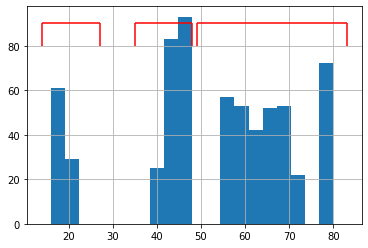

In [5]:
df['age'].hist(bins=20)
age_limits_in_weeks= [(2,3), (5,6), (7,11)]
age_limits_in_days = [(x[0]*7,(x[1]+1)*7-1)   for x in age_limits_in_weeks]
for x in age_limits_in_days: 
    plt.vlines(x[0], 80, 90, 'r') 
    plt.vlines(x[1], 80, 90, 'r')
    plt.hlines(90, x[0],x[1], 'r') 

### Add age group by age

In [6]:
def assign_age_group(age): 
    
    age_limits_in_weeks= [(2,3), (5,6), (7,11)]  ## <--- set here range of weeks for each group
    
    age_limits_in_days = [(x[0]*7,(x[1]+1)*7-1)   for x in age_limits_in_weeks]
    
    for k, age_lim in enumerate(age_limits_in_days): 
        if (age_lim[0]<=age) & (age<= age_lim[1]): 
            return  "-".join(map(str,age_limits_in_weeks[k]))+' weeks'
            
            
df['age_group']=df['age'].apply(assign_age_group)

# Find detached cells or inactive

In [7]:
def patch_clamp_find_peaks(abf): 
    peaksPerFile=[]
    for sweep in abf.sweepList:
        mask = np.zeros((abf.sweepPointCount-1,))
        ind_range = np.argwhere(abf.sweepC > 0).T[0][150:-100]
        mask[ind_range] = 1
        # mask = np.ones((abf.sweepPointCount-1,))

        x = abf.sweepY 
        xf = gaussian_filter1d(x,120)
        divY = np.diff(xf)  * (abf.dataRate / 1000) * mask # V/s

        # divPeaks, properties = find_peaks( divY , prominence=[10, None], )#, width=[5, None])
        divPeaks, properties = find_peaks( divY ,  height=0.5,  prominence=[0.5, None], threshold=None, distance=None)

        peaks = []
        for dP in divPeaks: 
            prefix_offset = max(0,dP-200)
            peaksInWindow, properties = find_peaks( x[prefix_offset:dP+1000] , prominence=[1, None], width=[20, None])
            if peaksInWindow.shape[0]>0: 
                peaks.append(prefix_offset + peaksInWindow[0])
        peaksPerFile.extend(peaks)
    return peaksPerFile

In [8]:
rmsPerFile = []
numOfPeaks =[]
for idx, row in tqdm(df[df['protocol']=='current_clamp'].iterrows(), total=df[df['protocol']=='current_clamp'].shape[0]): 
   
    abf = pyabf.ABF(row['fname'])
    
    # sameCellIdx = df[df['uid']==row['uid']].index
    
    if abf.sweepCount<35: 
        df.loc[idx,'isValid'] = 0
        continue
        
    fig, (ax1, ax2) = plt.subplots(1,2,figsize=(40, 10))    
    rms_list =[]
    for sweep in abf.sweepList[10:]: 

        abf.setSweep(sweep)   

        x = abf.sweepY 
        xf = gaussian_filter1d(x,400)
        
        rms = np.sqrt(np.mean(np.square(x-xf)))
        rms_list.append(rms)
        offset = 10*sweep
        ax1.plot(x+offset)
        ax1.plot(xf+offset)
        ax2.plot(np.abs((x-xf)[9000:14000]) + offset)
        ax2.text(0, offset+5, str(rms))
        
        
        
        ## find any peaks
    peaks =  patch_clamp_find_peaks(abf)  
    numOfPeaks.append(len(peaks))
        
        
    numOfSweepsAboveThreshold = np.argwhere(np.array(rms_list) > 10).shape[0]
    
    if (numOfSweepsAboveThreshold > 5) or (len(peaks)<10) : 
        df.loc[idx,'isValid'] = 0
        fig.suptitle('file:{0}\nidx:{1}\n#peaks:{2}  -  #NoiseSweeps:{3}'.format(row['fname'], idx, len(peaks), numOfSweepsAboveThreshold))
        plt.savefig(r'detached_cells\{0}_{1}.png'.format(os.path.split(abf.abfFilePath)[-1][:-4], idx )) 
       
    else: 
        df.loc[idx,'isValid'] = 1
        
    plt.close()
    rmsPerFile.append([idx, rms_list])



  0%|          | 0/128 [00:00<?, ?it/s]

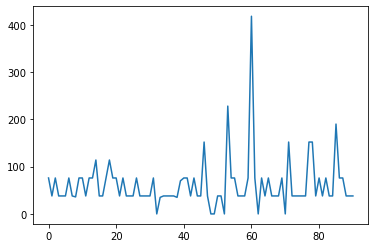

In [9]:
plt.plot(numOfPeaks)

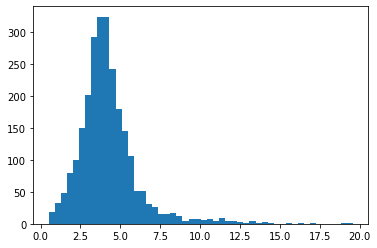

In [10]:
# rms stats (entire dataset)
tbl = []
for x in pd.DataFrame(rmsPerFile)[1].to_numpy(): 
    tbl += x
    
plt.hist(tbl, 50)
plt.show()

### check recrording for invalidity

In [11]:
# update valid flag for 'potassium currents detailed' by sweep count ==20
df.loc[(df['protocol']=='potassium currents detailed'),'isValid'] = df[(df['protocol']=='potassium currents detailed')].apply(lambda x: 1 if (x['sweepCount']==20) else 0, axis=1)

In [12]:
# update valid flag for 'spontaseous' by dataLengthSec > 50 & at least one 'current_clamp' of the same cell is valid
df.loc[(df['protocol']=='spontaseous'),'isValid'] = df[(df['protocol']=='spontaseous')].apply(lambda x: 1 if (
                    (x['dataLengthSec']>50) & 
                    (df[(df['uid'] == row['uid'] ) &( df['protocol'] =='current_clamp')]['isValid']==1).any()
                                                                                                             ) else 0, axis=1)

In [13]:
# update valid flag for 'spontanoues current' by dataLengthSec > 50 & at least one 'current_clamp' of the same cell is valid
df.loc[(df['protocol']=='spontanoues current'),'isValid'] = df[(df['protocol']=='spontanoues current')].apply(lambda x: 1 if (
                    (x['dataLengthSec']>50) & 
                    (df[(df['uid'] == row['uid'] ) &( df['protocol'] =='current_clamp')]['isValid']==1).any()
                                                                                                             ) else 0, axis=1)

In [14]:
df[df.isValid.isna()]

,Date,Line,age label,cell,uid,protocol,fname,dataLengthSec,sweepCount,cap,type,first_diff,age,age_group,isValid


In [16]:
df.to_csv('recordings.csv')

# ============================================

## Summary # of recording per protocol

In [17]:
df = pd.read_csv('recordings.csv', index_col=0)

#### All recording (include invalid)

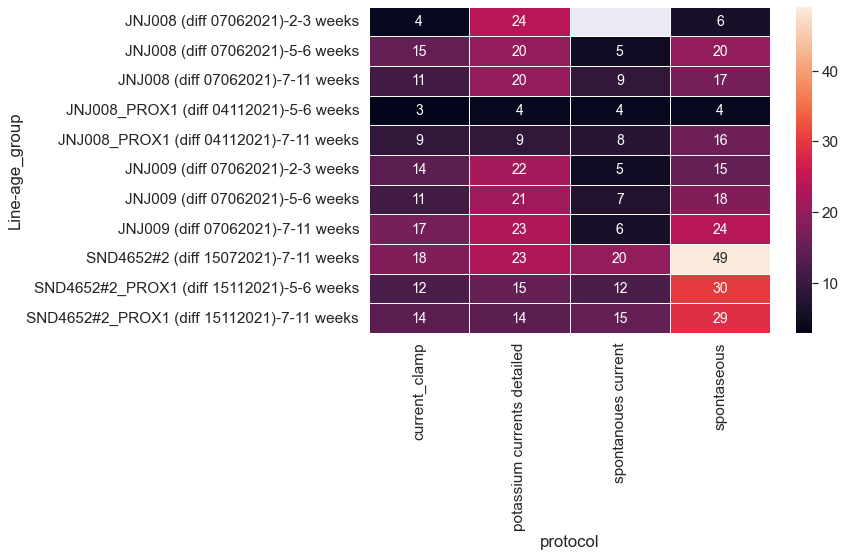

In [19]:
sns.set(font_scale=1.4)

msr_count_df_all = df.groupby(['Line','protocol', 'age_group'])['uid'].count()
msr_count_df_all.reset_index().pivot(['Line','age_group'], 'protocol','uid')

f, ax = plt.subplots(figsize=(9, 6))
sns.heatmap(data = msr_count_df_all.reset_index().pivot(['Line','age_group'], 'protocol','uid'), 
           annot=True,annot_kws ={'size':14}, linewidths=.5, ax=ax)
plt.show()

#### Only valid recordings

<AxesSubplot:xlabel='protocol', ylabel='Line-age_group'>

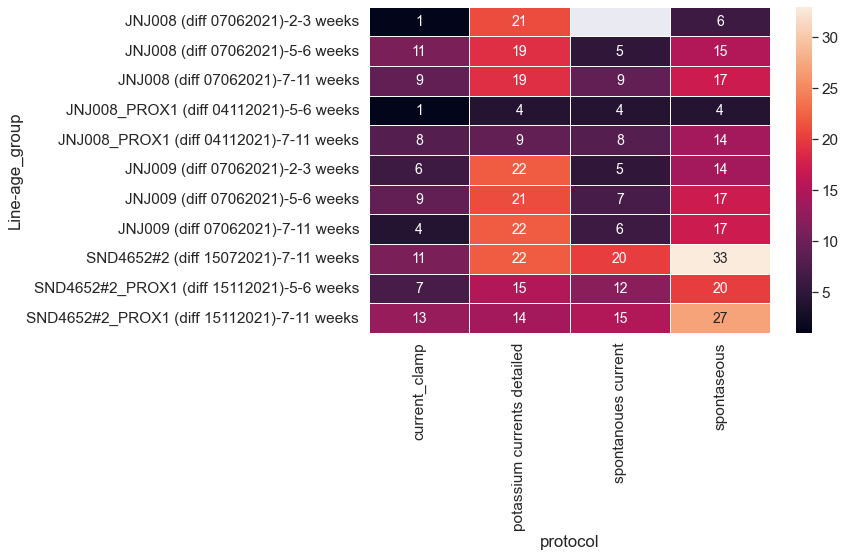

In [21]:
msr_count_df = df[df['isValid']==1].groupby(['Line','protocol', 'age_group'])['uid'].count()
msr_count_df.reset_index().pivot(['Line','age_group'], 'protocol','uid')

sns.set(font_scale=1.4)
f, ax = plt.subplots(figsize=(9, 6))

sns.heatmap(data = msr_count_df.reset_index().pivot(['Line','age_group'], 'protocol','uid'), 
           annot=True,annot_kws ={'size':14}, linewidths=.5, ax=ax)


#### Valid recordings (group into type)

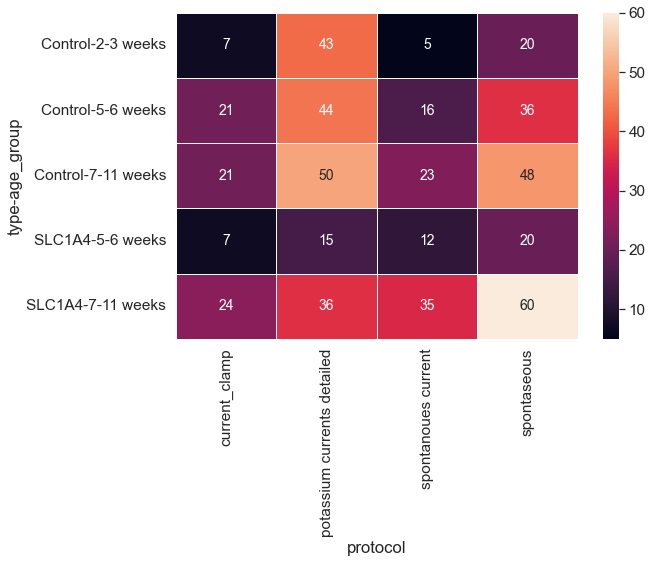

In [23]:
msr_count_df2 = df[df['isValid']==1].groupby(['type','protocol', 'age_group'])['uid'].count()
msr_count_df2.reset_index().pivot(['type','age_group'], 'protocol','uid')


sns.set(font_scale=1.4)
f, ax = plt.subplots(figsize=(9, 6))

sns.heatmap(data = msr_count_df2.reset_index().pivot(['type','age_group'], 'protocol','uid'), 
           annot=True,annot_kws ={'size':14}, linewidths=.5, ax=ax)
plt.show() 